In [ ]:
!wget https://purepng.com/public/uploads/large/nature-8gp.png

--2022-06-15 22:02:26--  https://purepng.com/public/uploads/large/nature-8gp.png
Resolving purepng.com (purepng.com)... 172.67.210.15, 104.21.42.203, 2606:4700:3031::6815:2acb, ...
Connecting to purepng.com (purepng.com)|172.67.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3329925 (3.2M) [image/png]
Saving to: ‘nature-8gp.png.3’

nature-8gp.png.3    100%[===================>]   3.17M  --.-KB/s    in 0.09s   

2022-06-15 22:02:26 (36.1 MB/s) - ‘nature-8gp.png.3’ saved [3329925/3329925]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  # Remove the CWD from sys.path while we load stuff.


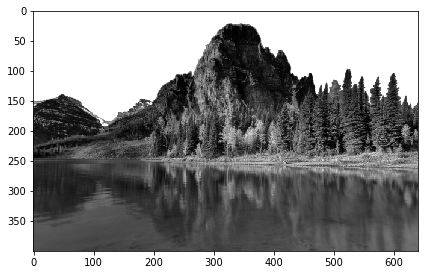

In [ ]:
%matplotlib inline
import requests
from skimage.io import imread, imsave, imshow
from skimage import img_as_ubyte, img_as_float
from skimage.transform import resize
from skimage.color import rgb2gray
import numpy as np


img_in = rgb2gray(imread('./nature-8gp.png'))
t = img_in.shape[0] // 400
img = resize(img_in, (img_in.shape[0] // t, img_in.shape[1] // t), anti_aliasing=True)
img = img_as_float(img)
imshow(img)

# Расчет гаусовской пирамиды и вывод изображений


Дальше все вычисления производятся для сигмы равной 1.5

In [ ]:
#Нахожденияе ядра Гауса
import math

def smoothing_nuc(x): # посчитаем функцию гаусса для ядра
  q = 1.5
  sum = 0
  a = np.empty((x, x))

  for i in range(x):
    for j in range(x):
      xx = i - x // 2
      yy = j - x // 2
      a[i][j] = 1 / (2 * math.pi * q ** 2) * math.exp(-(xx ** 2 + yy ** 2) / (2 * q ** 2))
      sum += a[i][j]

  a = a / sum
  return a

In [ ]:
#Функция для нулей по бокам
def borders(tab, n, m, x):
  k = x // 2
  col = np.zeros((k, m))
  row = np.zeros((n + k * 2, k))
  tab = np.vstack([col, tab, col])
  tab = np.hstack([row, tab, row])
  return tab

In [ ]:
#Функция применения ядра к изображению
def one_color(tab, n, m, x, nuc):
  k = x // 2
  ans = np.ones((n, m))
  for i in range(k, n + k):
    for j in range(k, m + k):
      slave = tab[i-k:i+k + 1, j-k:j+k + 1]
      t = np.zeros((x, x))
      for ii in range(x):
        for jj in range(x):
          t[ii][jj] = slave[ii][jj] * nuc[ii][jj]
      ans[i-k][j-k] = np.sum(t)
  return ans

In [ ]:
from numpy.lib.shape_base import apply_along_axis
#Сама функция сглаживания
def smoothing(img, x):
  nuc = smoothing_nuc(x)

  n = img.shape[0]
  m = img.shape[1]
  
  bordered = borders(img[:, :], n, m, x)

  ans = one_color(bordered, n, m, x, nuc)
  ans = np.clip(ans, 0, 1)
  return ans

In [ ]:
def gauss_pyramid(insert_img, x, layers):
  ans = []
  ans.append(insert_img)
  for i in range(1, layers):
    new_lay = smoothing(ans[i - 1], x)
    ans.append(new_lay)
  return ans

In [ ]:
number_of_layers = 7
nuc_x = 7
pyram = gauss_pyramid(img, nuc_x, number_of_layers)
freq = []
for i in range(number_of_layers):
  form = np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(pyram[i]))))
  freq.append(form)

Дальше выводим все изображения и их частоты по очереди

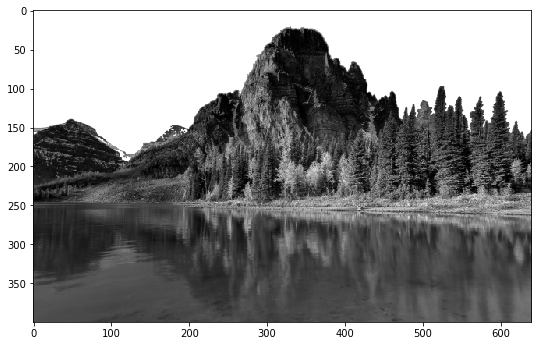

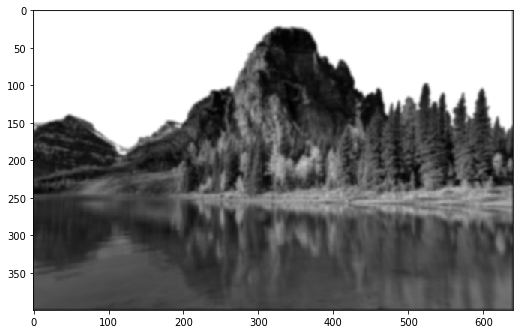

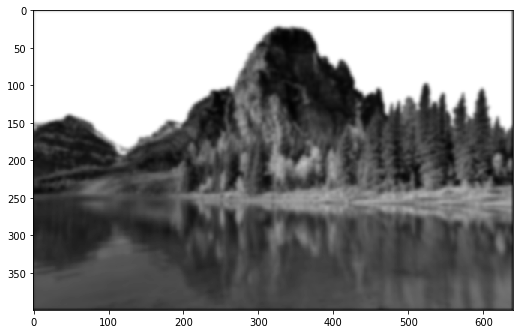

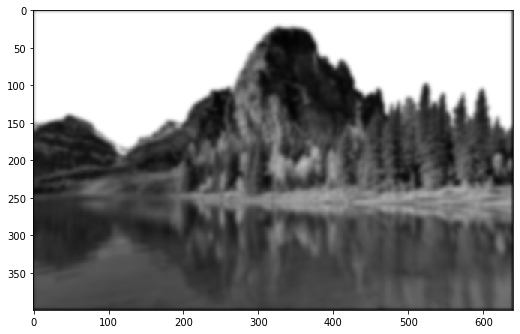

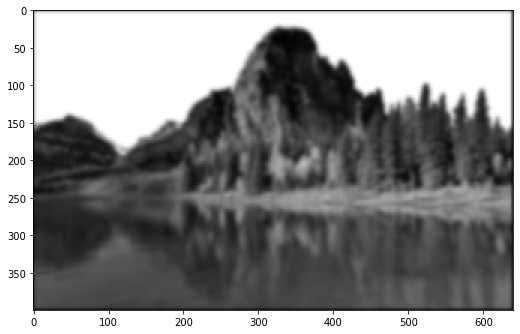

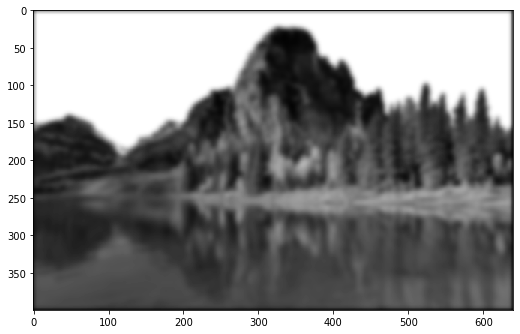

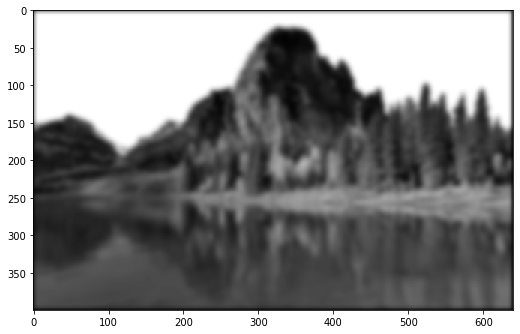

In [ ]:
import matplotlib.pyplot as plt

for i in range(number_of_layers):
  n = pyram[i].shape[0]
  m = pyram[i].shape[1]
  plt.figure(figsize=(50, 50))
  plt.subplot(1,number_of_layers,i+1)
  imshow(pyram[i])


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


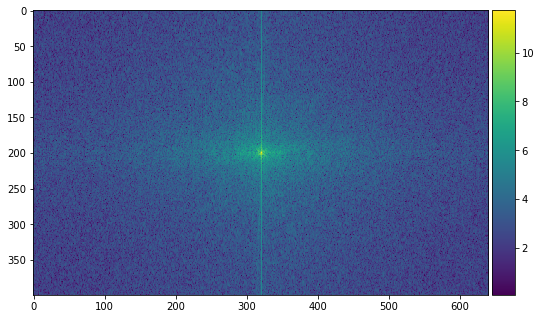

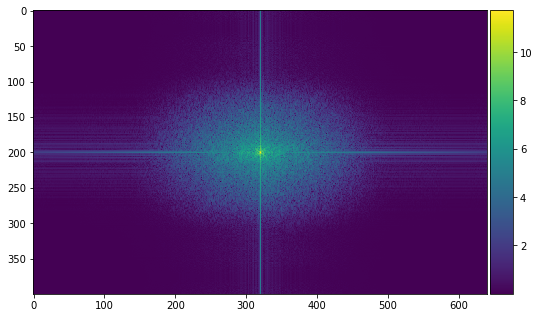

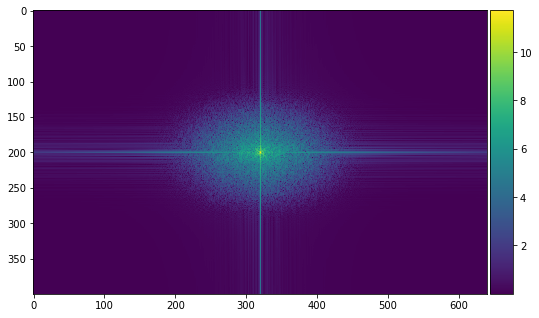

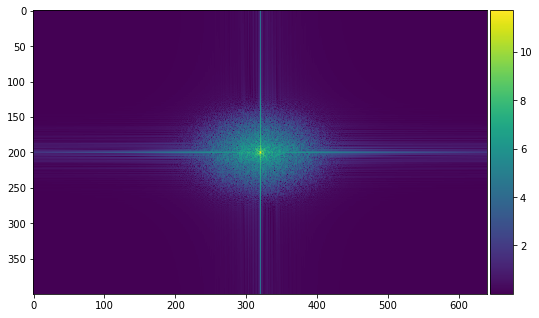

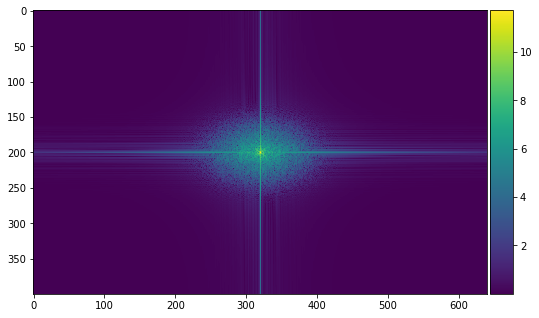

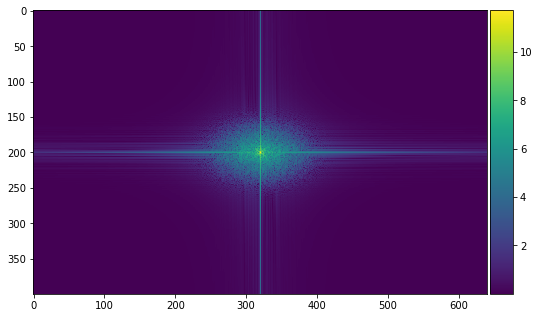

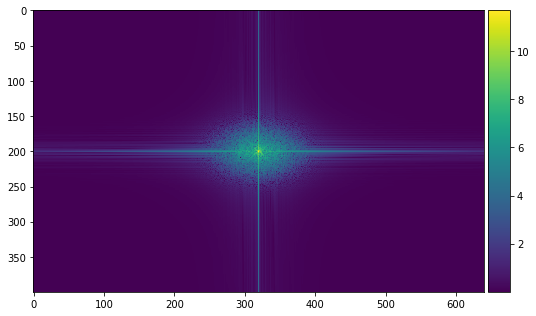

In [ ]:
for i in range(number_of_layers):
  n = pyram[i].shape[0]
  m = pyram[i].shape[1]
  plt.figure(figsize=(50, 50))
  plt.subplot(1,number_of_layers,i+1)
  imshow(freq[i])

# Рассчет лаплассовской пирамиды 

In [ ]:
def laplass_pyramid(insert_img, x, layers):
  gauss = gauss_pyramid(insert_img, x, layers)
  ans = []
  for i in range(1, layers):
    new_lay = gauss[i] - gauss[i - 1]
    ans.append(np.clip(new_lay, 0, 1))
  ans.append(gauss[layers - 1])
  return ans

In [ ]:
pyram2 = laplass_pyramid(img, nuc_x, number_of_layers)
freq2 = []
for i in range(number_of_layers):
  form = np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(pyram2[i]))))
  freq2.append(form)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


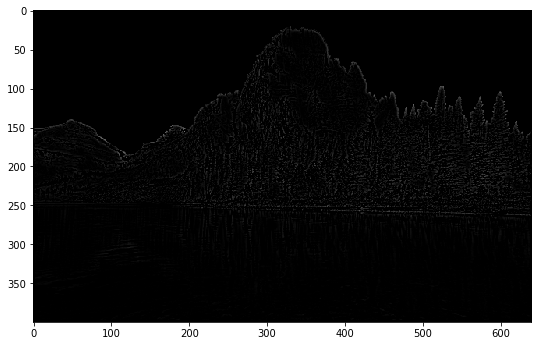

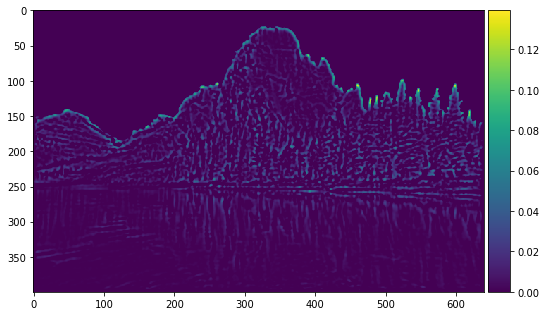

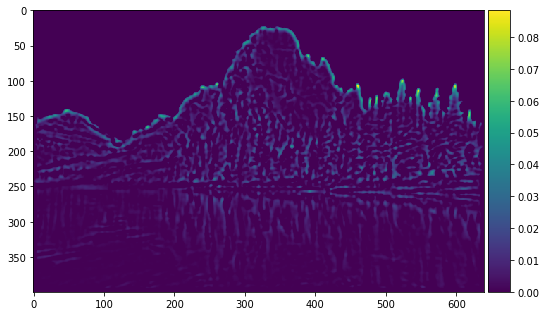

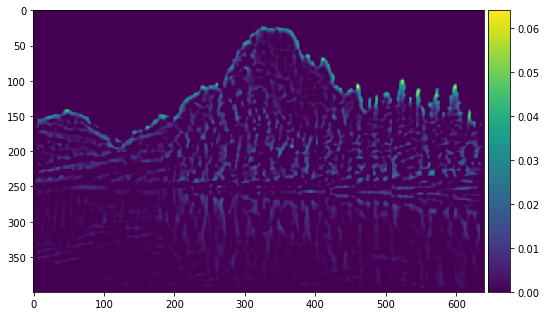

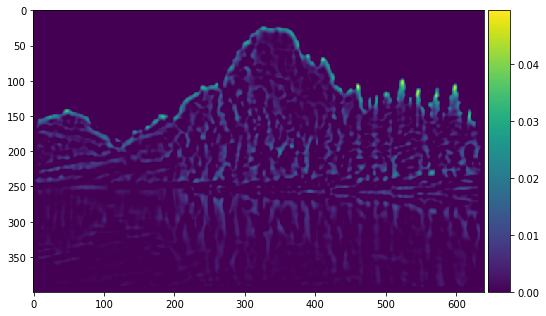

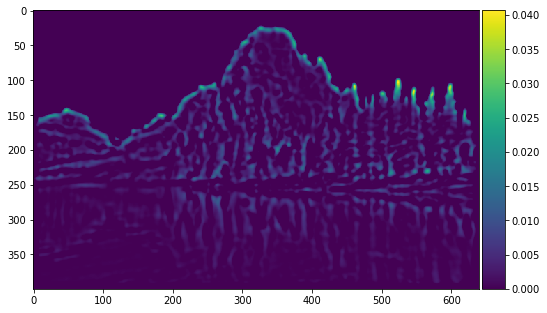

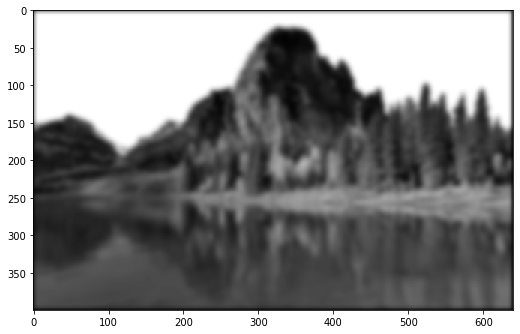

In [ ]:
for i in range(number_of_layers):
  n = pyram2[i].shape[0]
  m = pyram2[i].shape[1]
  plt.figure(figsize=(50, 50))
  plt.subplot(1,number_of_layers,i+1)
  imshow(pyram2[i])

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


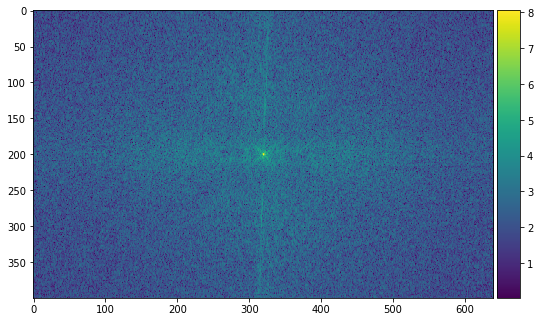

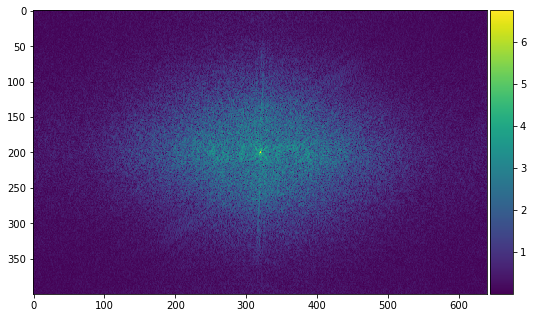

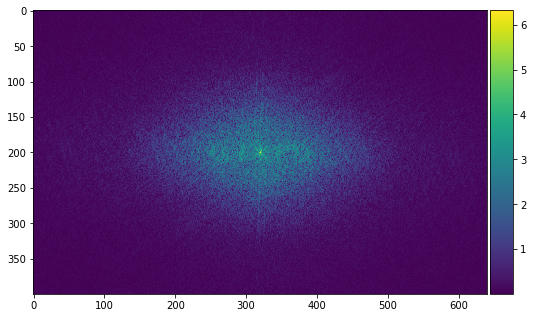

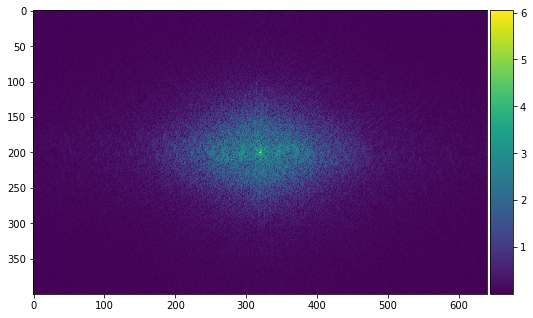

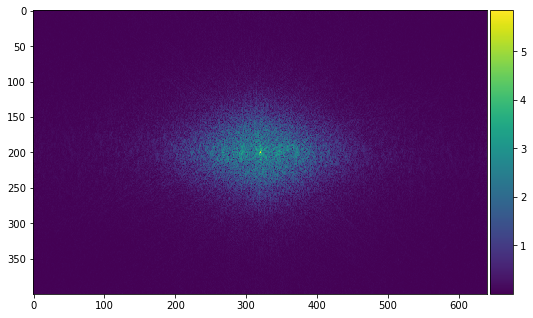

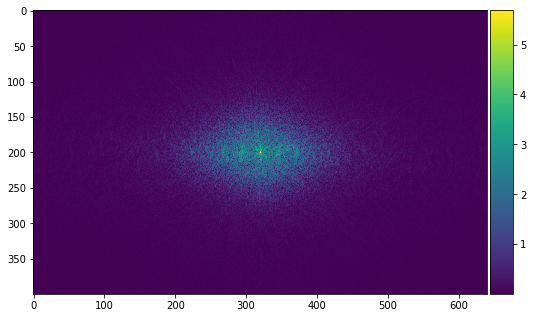

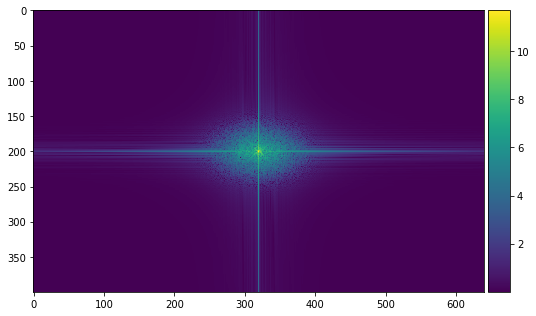

In [ ]:
for i in range(number_of_layers):
  n = pyram[i].shape[0]
  m = pyram[i].shape[1]
  plt.figure(figsize=(50, 50))
  plt.subplot(1,number_of_layers,i+1)
  imshow(freq2[i])

# Склейка

In [ ]:
!wget https://stepik.org/media/attachments/lesson/58410/a.png
!wget https://stepik.org/media/attachments/lesson/58410/b.png
!wget https://stepik.org/media/attachments/lesson/58410/mask.png

--2022-06-16 02:25:26--  https://stepik.org/media/attachments/lesson/58410/a.png
Resolving stepik.org (stepik.org)... 13.69.75.239
Connecting to stepik.org (stepik.org)|13.69.75.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54296 (53K) [image/png]
Saving to: ‘a.png.2’

a.png.2             100%[===================>]  53.02K  --.-KB/s    in 0.1s    

2022-06-16 02:25:27 (496 KB/s) - ‘a.png.2’ saved [54296/54296]

--2022-06-16 02:25:27--  https://stepik.org/media/attachments/lesson/58410/b.png
Resolving stepik.org (stepik.org)... 13.69.75.239
Connecting to stepik.org (stepik.org)|13.69.75.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50097 (49K) [image/png]
Saving to: ‘b.png.2’

b.png.2             100%[===================>]  48.92K  --.-KB/s    in 0.1s    

2022-06-16 02:25:27 (464 KB/s) - ‘b.png.2’ saved [50097/50097]

--2022-06-16 02:25:27--  https://stepik.org/media/attachments/lesson/58410/mask.png
Resolving stepik.org (

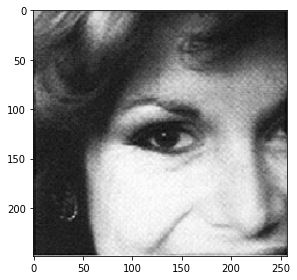

In [ ]:
imgA_in = rgb2gray(imread("./a.png"))
imgA = img_as_float(imgA_in)
imshow(imgA)

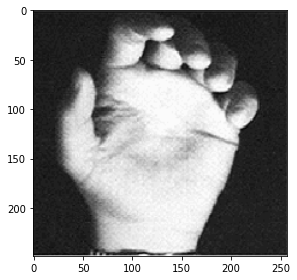

In [ ]:
imgB_in = rgb2gray(imread('./b.png'))
imgB = img_as_float(imgB_in)
imshow(imgB)

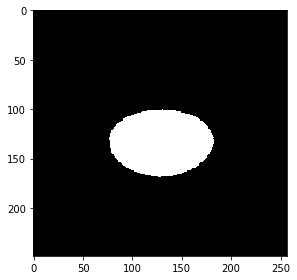

In [ ]:
#Считаем пирамиду Гаусса для маски
mask_in = rgb2gray(imread('mask.png'))
mask_in = (mask_in > 0.5)
mask = img_as_float(mask_in)
imshow(mask)

In [ ]:
#Рассчитываем пирамиды для обоих изображений
def merge(img1, img2, mask_for_first, needed_x, needed_layers):
  laplassA = laplass_pyramid(img1, needed_x, needed_layers)
  laplassB = laplass_pyramid(img2, needed_x, needed_layers)
  gaussM = gauss_pyramid(mask_for_first, needed_x, needed_layers)
  conseq = []
  for i in range(needed_layers):
    comb = laplassA[i] * gaussM[i] + laplassB[i] * (1 - gaussM[i])
    conseq.append(comb)
  ans = conseq[0]
  for i in range(1, needed_layers):
    ans += conseq[i]

  return np.clip(ans, 0, 1)

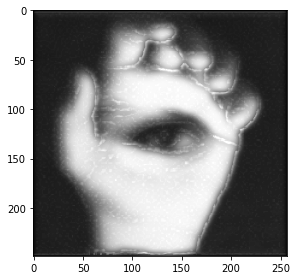

In [ ]:
ans = merge(imgA, imgB, mask, 7, 6)
imshow(ans)

# Коллажи


In [ ]:
def collage(img1, img2, mask_for_first, x, y):
  print(x, y)
  img1_res = resize(img1, (x, y), anti_aliasing=True)
  img2_res = resize(img2, (x, y), anti_aliasing=True)
  mask_res = resize(mask_for_first, (x, y), anti_aliasing=True)
  ans = merge(img1_res, img2_res, mask_res, 7, 7)
  return ans

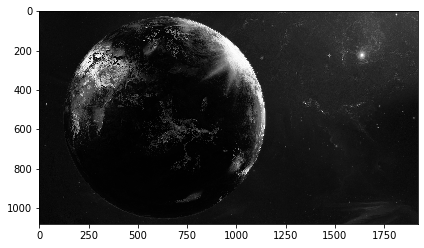

In [ ]:
A1 = rgb2gray(imread('./Wallpaper03.png'))
imshow(A1)

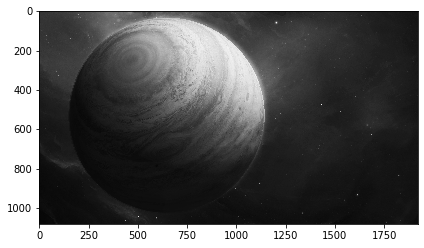

In [ ]:
B1 = rgb2gray(imread('./Wallpaper01.png'))
imshow(B1)

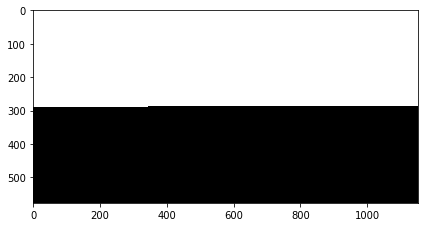

In [ ]:
mask1 = rgb2gray(imread('./Mask1.png'))
imshow(mask1)

270 480


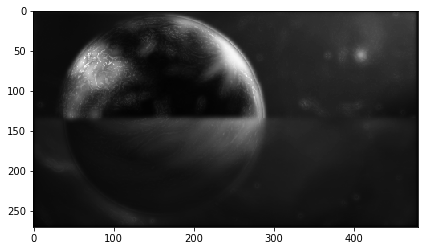

In [ ]:
imshow(collage(A1, B1, mask1, 1080 // 4, 1920 // 4))